In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sc_stats

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 12,
  'grid.alpha': 0.25})


## Function declarations

### Read `ods` to `DataFrame`


In [3]:
def read_ods(filename, columns):
  key_arr = (k for k in columns.keys())
  df = pd.read_excel(filename, engine="odf", header=0,
                     usecols=columns)
  df = df.rename(columns=columns)
  return df


### Get accuracy measures

In [4]:
def get_accuracy_measures(dataframe, columns=["Y_t", "hat_Y_t"]):
  Y_t = dataframe[columns[0]]
  hat_Y_t = dataframe[columns[1]]

  MAPE = (((Y_t - hat_Y_t).abs())/Y_t.abs()).mean()
  MAD = (Y_t - hat_Y_t).abs().mean()
  MSD = ((Y_t - hat_Y_t)**2).mean()
  
  return MAPE, MAD, MSD

  

### Standard error of autocorrelation


In [5]:
def std_error(r_k_arr, k, n):
  r_k_arr = np.array(r_k_arr)
  r_k_arr = r_k_arr[:k-1] if len(r_k_arr) > 1 else [0]
  r_k_arr = np.array(r_k_arr)
  return np.sqrt((1 + 2*sum(r_k_arr**2))/n)


### Compute `r_k`, `t_test`, and `LBQ`

In [6]:
def get_correlogram(dataframe, up_to_lag, columns=[None, None], 
                    significance_lvl=0.05):
  df = dataframe.copy()

  Y_t = df[columns[1]].to_numpy()

  mean_Y_t = np.mean(Y_t)

  r_lag_arr = np.empty(up_to_lag)
  denom = np.sum((Y_t - mean_Y_t)**2)

  num_of_samples = len(Y_t)
  dof = num_of_samples - 1   # degree of freedom
  l_bound = sc_stats.t.ppf(significance_lvl/2, dof)
  u_bound = sc_stats.t.ppf(1-significance_lvl/2, dof)
  #print(f"[l_bound, r_bound] = [{l_bound}, {u_bound}]")

  std_error_arr = np.empty(up_to_lag)
  significance_lim_arr = np.empty([up_to_lag, 2])

  t_test_arr = np.empty(up_to_lag)

  # Ljung-Box Q statistic
  coeff = num_of_samples*(num_of_samples + 2)
  LBQ_arr = np.empty(up_to_lag)

  for lag in range(1, up_to_lag+1):
    numer = (Y_t[:-lag]  - mean_Y_t) * (Y_t[lag:] - mean_Y_t)
    numer = np.sum(numer)
    # print(f"numer = {numer}")
    # print(f"denom = {denom}")
    r_lag = numer / denom
    r_lag_arr[lag-1] = r_lag 
    std_error_arr[lag-1] = std_error(r_lag_arr[:lag], lag, num_of_samples)
    #print(f"std_error_r_{lag:<2d}: {std_error_arr[lag-1]}")
    significance_lim_arr[lag-1, 0] = l_bound*std_error_arr[lag-1]
    significance_lim_arr[lag-1, 1] = u_bound*std_error_arr[lag-1]

    t_test_arr[lag-1] = r_lag / std_error_arr[lag-1]
    # print(f"r_{lag:<2d} = {r_lag_arr[lag-1]:9.6f}")

    LBQ_arr[lag-1] = coeff*np.sum((r_lag_arr[:lag]**2)/(num_of_samples - np.arange(1, lag+1)))


  df_result = pd.DataFrame({
    "k": np.arange(1, up_to_lag+1), 
    "r_k": r_lag_arr, 
    "t_test": t_test_arr, 
    "LBQ": LBQ_arr,
    "l_bound": significance_lim_arr[:,0],
    "u_bound": significance_lim_arr[:,1]  
  })
  return df_result

### Plot of autocorrelation function

In [7]:
def plot_autocorr_func(df_acorr_analysis, title=None):
  fig, ax = plt.subplots(figsize=(7, 3))

  lag_arr = df_acorr_analysis["k"].to_numpy()
  stem_handler = ax.stem(lag_arr, df_acorr_analysis["r_k"].to_numpy())

  ax.plot(lag_arr, df_acorr_analysis["l_bound"], linestyle='--', color="gray")
  ax.plot(lag_arr, df_acorr_analysis["u_bound"], linestyle='--', color="gray")

  # [0] = markerline handler
  # [1] = stemlines handler
  # [2] = baseline handler
  stem_handler[0].set_marker(None)
  stem_handler[1].set_linewidth(4)
  stem_handler[2].set_alpha(0)

  ax.grid("on")
  ax.set_ylim([-1.1, 1.1])
  ax.set_xlabel("Lag")
  ax.set_ylabel("Autocorrelation")
  ax.set_title(f"Autocorrelation Function for {title}\n"
    + "(with 5% significance limits for the autocorrelations)")

  plt.show(fig)


## Load the data

In [8]:
filename = "03-table-03-weekly-rentals-movie.ods"
df = read_ods(filename, 
  {"t": "t", 
   "Weekly Units Rented": "Y_t"})

# add one additional row at the end of dataframe
df.loc[len(df)] = [16, np.NaN]
df


,t,Y_t
0,1.0,654.0
1,2.0,658.0
2,3.0,665.0
3,4.0,672.0
4,5.0,673.0
5,6.0,671.0
6,7.0,693.0
7,8.0,694.0
8,9.0,701.0
9,10.0,703.0


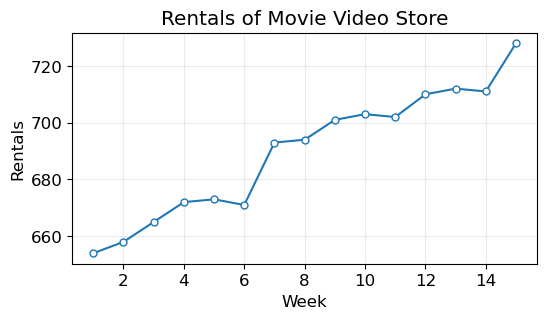

In [9]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(df["t"], df["Y_t"], marker='o', markersize=5, 
  markerfacecolor="white")
ax.set_xlabel("Week")
ax.set_ylabel("Rentals")
ax.set_title("Rentals of Movie Video Store")
ax.grid("on")
plt.show(fig)


## Forecasting (single moving average)

In [10]:
df_forecast_single = df.copy()

k = 3
df_forecast_single["sum_Y_t"] = df_forecast_single["Y_t"].rolling(window=k).sum()
df_forecast_single["hat_Y_tP1"] = (df_forecast_single["sum_Y_t"]/k).shift(1)
df_forecast_single["e_t"] = df_forecast_single["Y_t"] - df_forecast_single["hat_Y_tP1"]
df_forecast_single


,t,Y_t,sum_Y_t,hat_Y_tP1,e_t
0,1.0,654.0,NaN,NaN,NaN
1,2.0,658.0,NaN,NaN,NaN
2,3.0,665.0,1977.0,NaN,NaN
3,4.0,672.0,1995.0,659.000000,13.000000
4,5.0,673.0,2010.0,665.000000,8.000000
5,6.0,671.0,2016.0,670.000000,1.000000
6,7.0,693.0,2037.0,672.000000,21.000000
7,8.0,694.0,2058.0,679.000000,15.000000
8,9.0,701.0,2088.0,686.000000,15.000000
9,10.0,703.0,2098.0,696.000000,7.000000


## Forecasting (double moving average)

$$
\begin{gather*}
  \hat{Y}_{t+1} = a_t + b_t \, p \\
  M_t = \hat{Y}_{t+1} =  \frac{Y_t + Y_{t-1} + Y_{t-2} + \ldots + Y_{t-k+1}}{k} \\
  M'_t = \frac{M_t + M_{t-1} + M_{t-2} + \ldots + M_{t-k+1}}{k} \\
  a_t = M_t + (M_t - M'_t) = 2M_t - M'_t \\
  b_t = \frac{2}{k-1} (M_t - M'_t) \\

  \hat{Y}_{t+p} = a_t + p \, b_t
\end{gather*}
$$

In [11]:
df_forecast = df.copy()

k = 3
p = 1

# To get the same MSE or MSD in the textbook 
# we have to round the numbers
df_forecast["M_t"] = df_forecast["Y_t"].rolling(window=k).mean().round()
df_forecast["M_t_prime"] = df_forecast["M_t"].rolling(window=k).mean().round()

df_forecast["a_t"] = 2*df_forecast["M_t"] - df_forecast["M_t_prime"]
df_forecast["b_t"] = (2/(k-1)) * (df_forecast["M_t"] - df_forecast["M_t_prime"])
df_forecast["hat_Y_t_p"] = (df_forecast["a_t"] + df_forecast["b_t"]*p).shift(p)
df_forecast["e_t"] = df_forecast["Y_t"] - df_forecast["hat_Y_t_p"]

df_forecast

,t,Y_t,M_t,M_t_prime,a_t,b_t,hat_Y_t_p,e_t
0,1.0,654.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,658.0,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,665.0,659.0,NaN,NaN,NaN,NaN,NaN
3,4.0,672.0,665.0,NaN,NaN,NaN,NaN,NaN
4,5.0,673.0,670.0,665.0,675.0,5.0,NaN,NaN
5,6.0,671.0,672.0,669.0,675.0,3.0,680.0,-9.0
6,7.0,693.0,679.0,674.0,684.0,5.0,678.0,15.0
7,8.0,694.0,686.0,679.0,693.0,7.0,689.0,5.0
8,9.0,701.0,696.0,687.0,705.0,9.0,700.0,1.0
9,10.0,703.0,699.0,694.0,704.0,5.0,714.0,-11.0


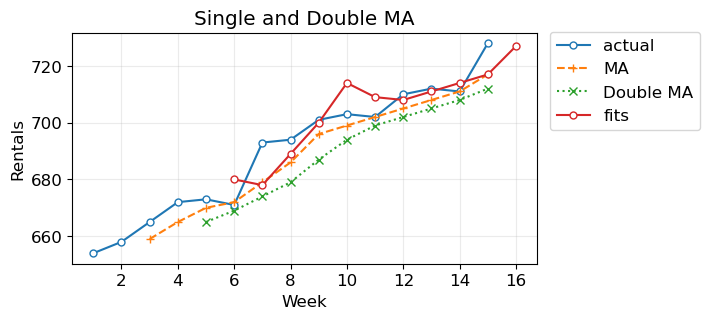

In [12]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(df_forecast["t"], df_forecast["Y_t"], 
  marker='o', markersize=5, markerfacecolor='white',
  label="actual")
ax.plot(df_forecast["t"], df_forecast["M_t"], 
  marker='+', markersize=6, linestyle='--', label="MA")
ax.plot(df_forecast["t"], df_forecast["M_t_prime"],
  marker='x', markersize=6, linestyle=':', label="Double MA")
ax.plot(df_forecast["t"], df_forecast["hat_Y_t_p"], 
  marker='o', markersize=5, markerfacecolor='white',
  label="fits")

ax.set_xlabel("Week")
ax.set_ylabel("Rentals")
ax.set_title("Single and Double MA")
ax.legend(loc="upper left", bbox_to_anchor=[1.01, 1.04])
ax.grid("on")
plt.show(fig)


### residual

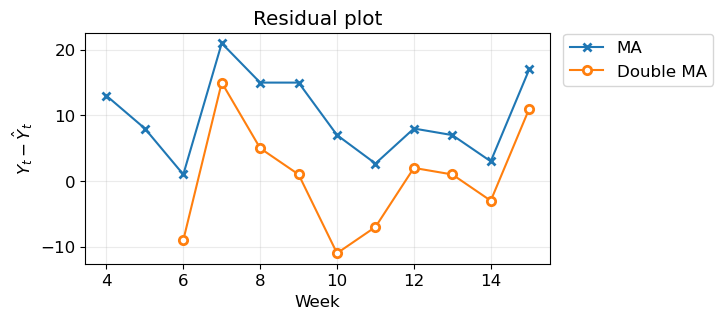

In [13]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(df_forecast_single["t"], df_forecast_single["e_t"], 
  marker='x', markeredgewidth=2, label="MA")

ax.plot(df_forecast["t"], df_forecast["e_t"], 
  marker='o', markerfacecolor="white", markeredgewidth=2, 
  label="Double MA")

ax.set_xlabel("Week")
ax.set_ylabel("$Y_t - \hat{Y}_t$")
ax.set_title("Residual plot")
ax.legend(loc="upper left", bbox_to_anchor=(1.01, 1.03))
ax.grid("on")
plt.show(fig)


#### Accuracy measures (Single moving average)

In [14]:
# Dataframe is from `df_forecast_single`
MAPE, MAD, MSD = get_accuracy_measures(df_forecast_single, columns=["Y_t", "hat_Y_tP1"])
print(f"MAPE   {MAPE*100:8.3f}")
print(f"MAD    {MAD:8.3f}")
print(f"MSD    {MSD:8.3f}")


MAPE      1.404
MAD       9.806
MSD     132.676


#### Accuracy measures (Double moving average)

In [15]:
MAPE, MAD, MSD = get_accuracy_measures(df_forecast, columns=["Y_t", "hat_Y_t_p"])
print(f"MAPE   {MAPE*100:8.3f}")
print(f"MAD    {MAD:8.3f}")
print(f"MSD    {MSD:8.3f}")


MAPE      0.929
MAD       6.500
MSD      63.700


#### Autocorrelation function for Double MA(3) residuals

In [18]:
num_of_rk = 6 
df_double_moveave = df_forecast.copy()
df_double_moveave = df_double_moveave.dropna().reset_index(drop=True)
df_acorr_analysis = get_correlogram(df_double_moveave, num_of_rk, columns=['t', "e_t"])
df_acorr_analysis


,k,r_k,t_test,LBQ,l_bound,u_bound
0,1,-0.061072,-0.193126,0.049730,-0.715357,0.715357
1,2,-0.176517,-0.556125,0.517104,-0.718020,0.718020
2,3,-0.265169,-0.810731,1.722500,-0.739893,0.739893
3,4,-0.048857,-0.140432,1.770241,-0.787024,0.787024
4,5,-0.042947,-0.123201,1.814508,-0.788575,0.788575
5,6,-0.027581,-0.079000,1.837329,-0.789771,0.789771


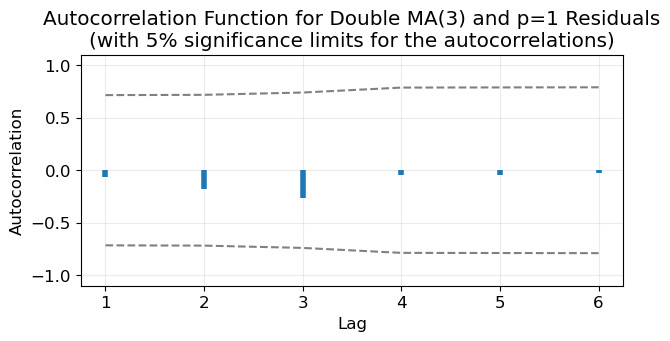

In [19]:
plot_autocorr_func(df_acorr_analysis, title="Double MA(3) and p=1 Residuals")